In [112]:
import os
os.chdir("/home/golopes/mestrado/projetos/FoodAid/")

import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])
from ingredient_parser import ingredient_parser
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from pattern.text.en import singularize

def _filter(token):
    if len(token) < 2:
        return False
    if token.is_stop:
        return False
    if token.text[0].islower():
        return False
    if token.is_digit:
        return False
    if token.like_num:
        return False
    return True

def _clean(text):
    text = text.replace("(", "")
    text = text.split("/")[0]
    return text

def get_labels(df, tokenized_instructions):
    # ingredients = df["ingredients"].apply(
    #     lambda x: ingredient_parser(x)
    # )
    labels = []
    dic_ing={}
    for ing, ti in zip(df["ingredients"], tokenized_instructions):
        l_i = []
        ci = ingredient_parser(ing)
        for i in ci:
            if i not in dic_ing.keys():
                dic_ing[i] = len(dic_ing)
        for token in ti:
            l_i.append(any((c == token.text or c == singularize(token.text) or singularize(c) == token.text) for c in ci))
        labels.append(l_i)
    return labels,dic_ing
            
def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [113]:
eval_size =5

df = pd.read_csv("csv_file/recipes.csv")

eval_df = df[eval_size:]
df = df[:eval_size]

tokenized = [nlp(t) for t in df.recipe.values]

vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if singularize(token.text) not in vocab.keys():
            vocab[singularize(token.text)] = len(vocab)
print("Number of unique tokens: {}".format(len(vocab)))

labels,dic_ing = get_labels(df, tokenized)


/home/golopes/anaconda3/envs/work/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Number of unique tokens: 117


In [114]:
i=1
print(tokenized[i])
print(df["ingredients"][i])
set([t.text for t, l in zip(tokenized[i], labels[i]) if l])

# dic_ing

In a bowl, mix the sweetened condensed coconut milk with the aquafaba. In another bowl, beat the aquafaba until stiff peaks form. Gradually add the coconut sugar while beating. Fold the aquafaba into the condensed coconut milk mixture. Pour the mixture into a cake pan and cover with foil. Place the pan in a larger pan and add water to the larger pan, until it reaches halfway up the sides of the smaller pan. Bake in the oven at 180°C for about 45 minutes. Remove from the oven and let it cool. Serve chilled. 
sweetened condensed coconut milk, aquafaba, coconut sugar, water


{'aquafaba', 'coconut', 'milk', 'sugar', 'water'}

In [115]:
MAX_LEN = 400
X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)

y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

model = tf.keras.Sequential([
    layers.Embedding(input_dim=len(vocab), mask_zero=True, output_dim=50),
    layers.SpatialDropout1D(0.2),
    layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)),
    layers.SpatialDropout1D(0.2),
    layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))
])

model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_seq, y_seq, epochs=10, batch_size=256, validation_split=0.1)

Epoch 1/10
1/1 [==============================] - 23s 23s/step - loss: 0.6927 - accuracy: 0.5378 - val_loss: 0.6771 - val_accuracy: 0.9020
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.6772 - accuracy: 0.9243 - val_loss: 0.6620 - val_accuracy: 0.9020
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.6608 - accuracy: 0.9243 - val_loss: 0.6433 - val_accuracy: 0.9020
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.6395 - accuracy: 0.9243 - val_loss: 0.6196 - val_accuracy: 0.9020
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.6126 - accuracy: 0.9243 - val_loss: 0.5895 - val_accuracy: 0.9020
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.5833 - accuracy: 0.9243 - val_loss: 0.5510 - val_accuracy: 0.9020
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.5428 - accuracy: 0.9243 - val_loss: 0.5028 - val_accuracy: 0.9020
Epoch 8/10
1/1 [=======================

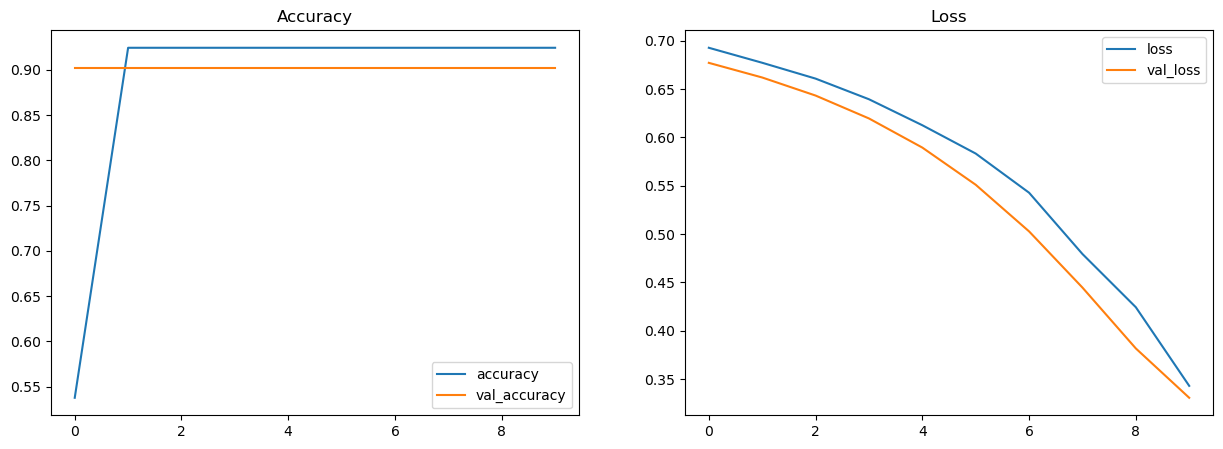

In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(history.history["accuracy"])
ax2.plot(history.history["loss"])
ax1.plot(history.history['val_'+"accuracy"])
ax2.plot(history.history['val_'+"loss"])
ax1.set_title("Accuracy")
ax2.set_title("Loss")
ax1.legend(["accuracy", 'val_'+"accuracy"])
ax2.legend(["loss", 'val_'+"loss"])

In [118]:
eval_ingredients = eval_df.ingredients.values
recipe=eval_df.recipe.values.tolist()
eval_tokenized = []
for t in recipe:
    try:
        eval_tokenized.append(nlp(t.replace("\n"," ")))
    except:
        print(t)

X_seq_test = prepare_sequences(eval_tokenized, max_len=MAX_LEN, vocab=vocab)

y_pred_test = model.predict(X_seq_test, verbose=1, batch_size=5)


/home/golopes/anaconda3/envs/work/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


15/15 [==============================] - 9s 202ms/step


In [121]:
i = 3
pred_i = y_pred_test[i] > 0.05
        
print(eval_tokenized[i])
print()
print(eval_ingredients[i])
print()
ingreds = [t.text for t, p in zip(eval_tokenized[i], pred_i) if p]
print(set(ingreds))
ing_ver=[]
for i in ingreds:
    if i in dic_ing.keys() and i not in ing_ver:
        ing_ver.append(i)
print(ing_ver)

Cook the aletria in boiling water for about 5 minutes, then drain and rinse it with cold water. In a pot, heat the milk with the cinnamon stick, orange zest and sugar. Once it starts boiling, add the aletria and let it cook until it thickens, stirring occasionally. Remove the cinnamon stick and orange zest, and stir in the butter until it melts. Transfer the aletria to a serving dish and let it cool. Cut the orange into small pieces and sprinkle over the top before serving.

aletria, milk, sugar, cinnamon stick, orange, butter 

{'minutes', '5', 'cook', 'aletria', 'and', 'melts', 'butter', 'Remove', 'before', 'small', 'it', 'starts', 'stick', '.', 'a', 'pot', 'for', 'with', 'zest', 'stirring', 'serving', 'let', 'thickens', 'top', 'cold', 'Cook', 'boiling', 'milk', 'heat', 'cinnamon', 'sugar', ',', 'to', 'Cut', 'into', 'pieces', 'rinse', 'In', 'then', 'until', 'Transfer', 'sprinkle', 'over', 'orange', 'the', 'occasionally', 'cool', 'water', 'add', 'stir', 'Once', 'about', 'dish', 'drain